In [103]:
#imports
import numpy as np
import simpy
from random import seed
from scipy.stats import t
from scipy.stats import ttest_ind
import random
import statistics
import matplotlib.pyplot as plt



In [259]:
number_of_servers = [1,2,4]

def simulate_mmn(mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random_seed, service_type):
    random.seed(random_seed)

    waitingTimes = []
    serviceTimes = []
    interarrivalTimes = []
    queue_lengths = []
    timestamps = []
    wt = [] 
    

    def generator(env, interval, server):  # customer generator with interarrival times.
        """generator generates customers randomly"""
        while True:
            service_time = get_service_time(service_type, mean_service_time)
            c = customer(env, f'Customer_{env.now:.2f}', server, service_time)
            env.process(c)
            t = random.expovariate(1.0/ interval)
            interarrivalTimes.append(t)
            yield env.timeout(t)  # adds time to the counter, does not delete from the memory

    def customer(env, name, server, service_time):
        # customer arrives to the system, waits and leaves
        arrive = env.now
        #print('%7.4f : Arrival time of %s' % (arrive, name))
        with server.request() as req:
            queue_entry_time = env.now

            results = yield req | env.timeout(arrive)
            
            if req in results:
                queue_time = env.now - queue_entry_time 
                servertime = service_time
                yield env.timeout(servertime)
                serviceTimes.append(servertime)

            else:
                waiting_time = env.now - arrive
                waitingTimes.append(waiting_time)
                queue_time = env.now - queue_entry_time

            wt.append(queue_time)
    
        

       
    def monitor(env, server):
        while True:
            queue_lengths.append(len(server.queue))
            timestamps.append(env.now)
            yield env.timeout(measurement_time_interval)


    
    def get_service_time(service_type, mean_service_time):
        if service_type == "Deterministic":
            return mean_service_time
        elif service_type == "Hyperexponential":
            a = 2.0
            b = 10.0
            if .75*a + .25*b != mean_service_time: 
                raise ValueError("means not the same")
            if random.random() < 0.75:
                return random.expovariate(1.0 / a)  # mean = 1.0
            else:
                return random.expovariate(1.0 / b)  # mean = 5.0

        else:  # Exponential (M/M/n)
            return random.expovariate(1.0 / mean_service_time)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n)  # capacity changes the number of generators in the system.
    env.process(generator(env, mean_interarrival, server))
    env.process(monitor(env, server))
    env.run(until=simulation_time)
    #interarrivalTimes.append(interarrival)

    dimension = int(simulation_time / measurement_time_interval)
    queue_lengths_matrix = np.array(queue_lengths[:dimension])

    average_interarrival = statistics.mean(interarrivalTimes)
    average_waitingTime = statistics.mean(waitingTimes) if waitingTimes else 0
    average_serviceTime = statistics.mean(serviceTimes)
    return {
        "servers": n,
        "average_interarrival": average_interarrival,
        "average_waitingTime": average_waitingTime,
        "average_serviceTime": average_serviceTime,
        "queue_lengths_matrix" : queue_lengths_matrix,
        "timestamps" : timestamps, 
        "waitingtimes": wt  
    }

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1+ confidence)/2, df=n-1)
    return mean, mean - t_value * std_err, mean + t_value * std_err  

system_load = 0.95
mean_service_time = 4
simulations = 50
servers = [1,2,4]
server_types = ["Deterministic", "Hyperexponential", "Markovian"]
simulation_time = 2000
measurement_time_interval = 5
random.seed(25)

service_rate = 1/mean_service_time
mean_interarrival_by_n = {n: 1 / (n*system_load * service_rate) for n in servers}

results = {stype: {n: [] for n in servers} for stype in server_types}
queue_length_matrices  = {stype: {n: [] for n in servers} for stype in server_types}

time_data = {stype: {n: [] for n in servers} for stype in server_types}




for server_type in server_types: 
    for n in servers:
        mean_interarrival = mean_interarrival_by_n[n]
        #print(f"Mean interarrival times by n: {mean_interarrival_by_n}")
        for _ in range(simulations):
            random_seed = random.randint(0,10000)
            result = simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random.randint(0, 10000), server_type)
            results[server_type][n].append(result['average_waitingTime'])
            queue_length_matrices[server_type][n].append(result['queue_lengths_matrix'])
            time_data[server_type][n].append(result['timestamps'])
            #break


print("\nSimulation results for n=1, 2, and 4 with Confidence Intervals:\n")
for server_type in server_types: 
    print(f"\n Testing for server type {server_type} \n")
    for n in servers:
        mean, ci_lower, ci_upper = confidence_interval(results[server_type][n]) 
        print(
            f"Servers: {n}, "
            f"Mean Waiting Time: {mean:.4f}, "
            f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})"
        )
        print()



Simulation results for n=1, 2, and 4 with Confidence Intervals:


 Testing for server type Deterministic 

Servers: 1, Mean Waiting Time: 1.1778, 95% CI: (0.5423, 1.8134)

Servers: 2, Mean Waiting Time: 0.8005, 95% CI: (0.3911, 1.2098)

Servers: 4, Mean Waiting Time: 0.3053, 95% CI: (0.0885, 0.5221)


 Testing for server type Hyperexponential 

Servers: 1, Mean Waiting Time: 4.6174, 95% CI: (1.9252, 7.3096)

Servers: 2, Mean Waiting Time: 3.2835, 95% CI: (1.3906, 5.1763)

Servers: 4, Mean Waiting Time: 0.6292, 95% CI: (-0.0858, 1.3441)


 Testing for server type Markovian 

Servers: 1, Mean Waiting Time: 4.6233, 95% CI: (2.2315, 7.0150)

Servers: 2, Mean Waiting Time: 1.3335, 95% CI: (0.5581, 2.1088)

Servers: 4, Mean Waiting Time: 0.7391, 95% CI: (0.0984, 1.3797)



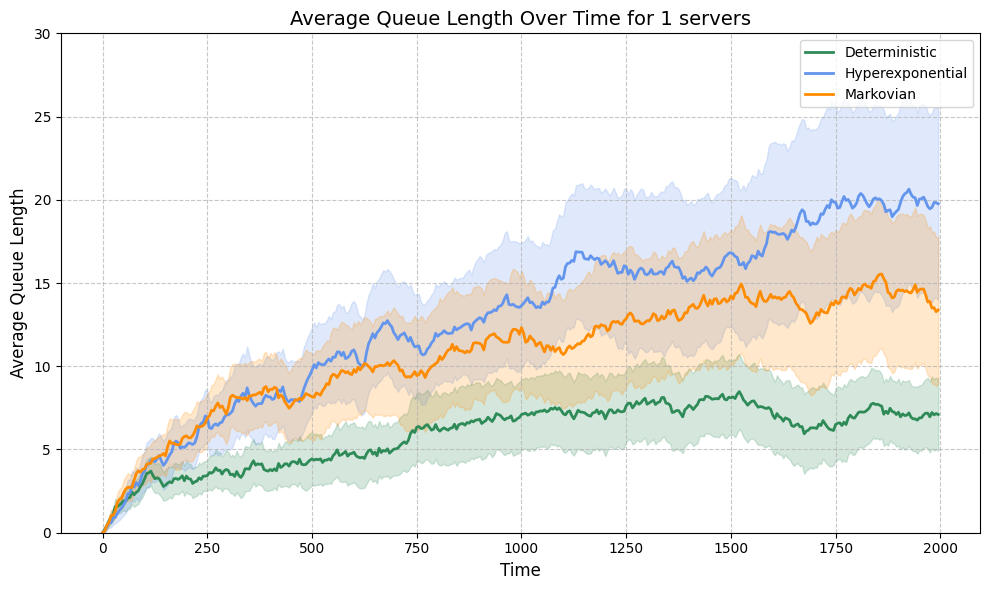

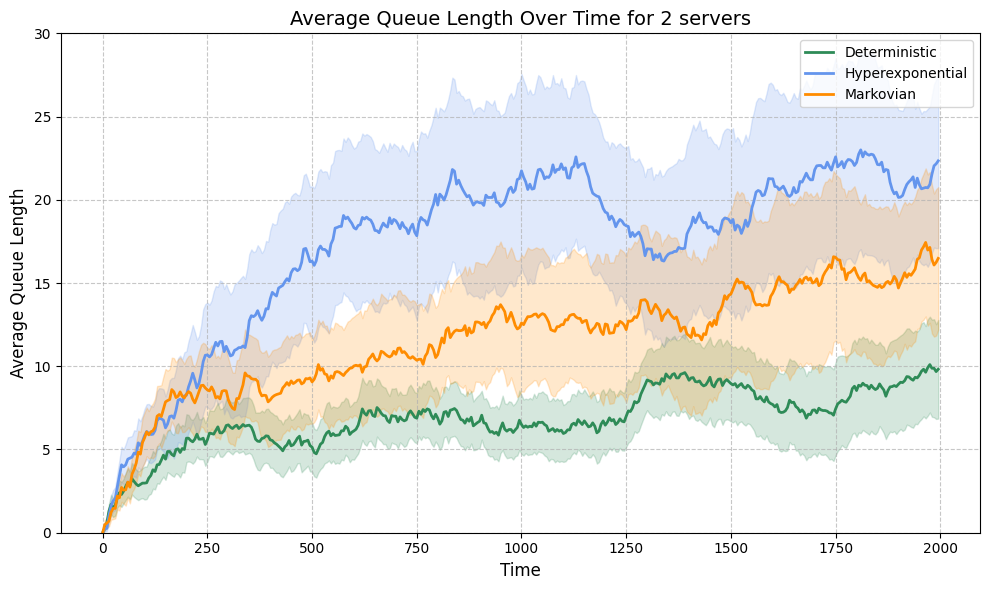

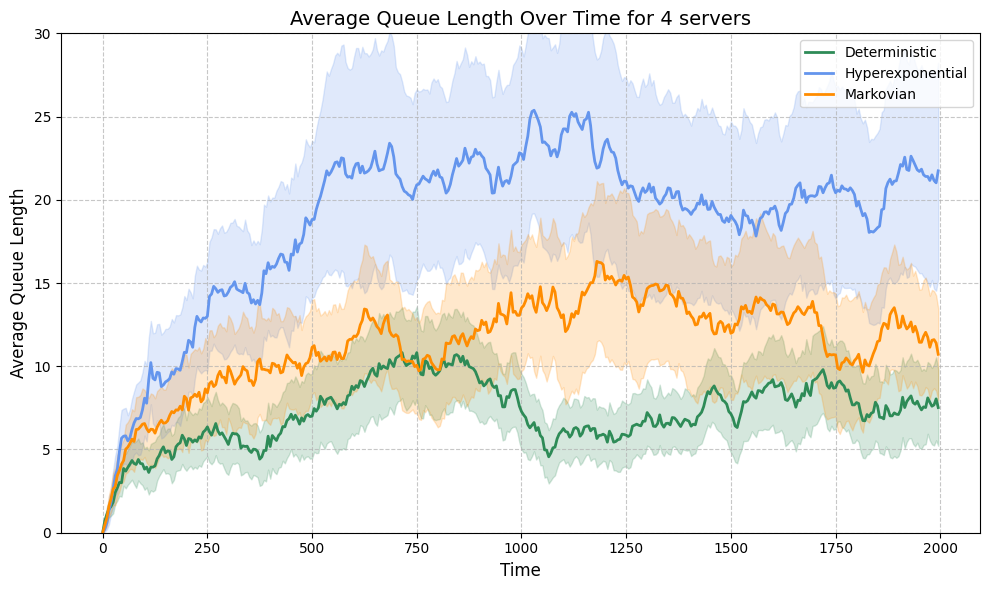

In [264]:
# Compute average queue length and confidence intervals for each time step
colors = ["seagreen", "cornflowerblue", "darkorange"] 



for n in number_of_servers: 
    plt.figure(figsize=(10, 6))
    for server_type in server_types:
        plot_data = {}
        q_lengths_matrix = np.array(queue_length_matrices[server_type][n])
        averages = np.mean(q_lengths_matrix, axis=0)
        std_dev = np.std(q_lengths_matrix, axis=0, ddof=1)
        ci_lower = averages - 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])
        ci_upper = averages + 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])

        time_steps = np.arange(q_lengths_matrix.shape[1]) * measurement_time_interval 

        plot_data[server_type] = {
            "time_steps": time_steps,
            "averages": averages,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        }

        time_steps = plot_data[server_type]["time_steps"]
        averages = plot_data[server_type]["averages"]
        ci_lower = plot_data[server_type]["ci_lower"]
        ci_upper = plot_data[server_type]["ci_upper"]

        # Plot averages and confidence intervals
        plt.plot(time_steps, averages, label=f'{server_type}', linewidth=2, color = colors[server_types.index(server_type)])
        plt.fill_between(time_steps, ci_lower, ci_upper, alpha=0.2, color = colors[server_types.index(server_type)])
    # Add plot details
    plt.title(f"Average Queue Length Over Time for {n} servers", fontsize=14)
    plt.ylim(0,30)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Average Queue Length", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"opdr4_{n}_servers.png", dpi=300)

    plt.show()



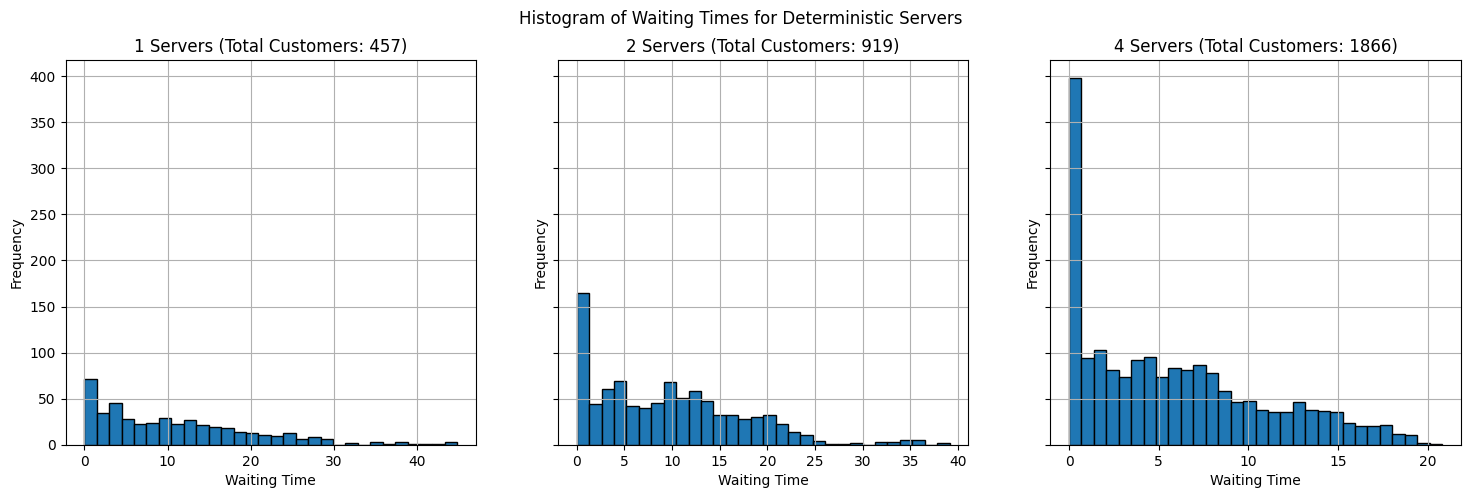

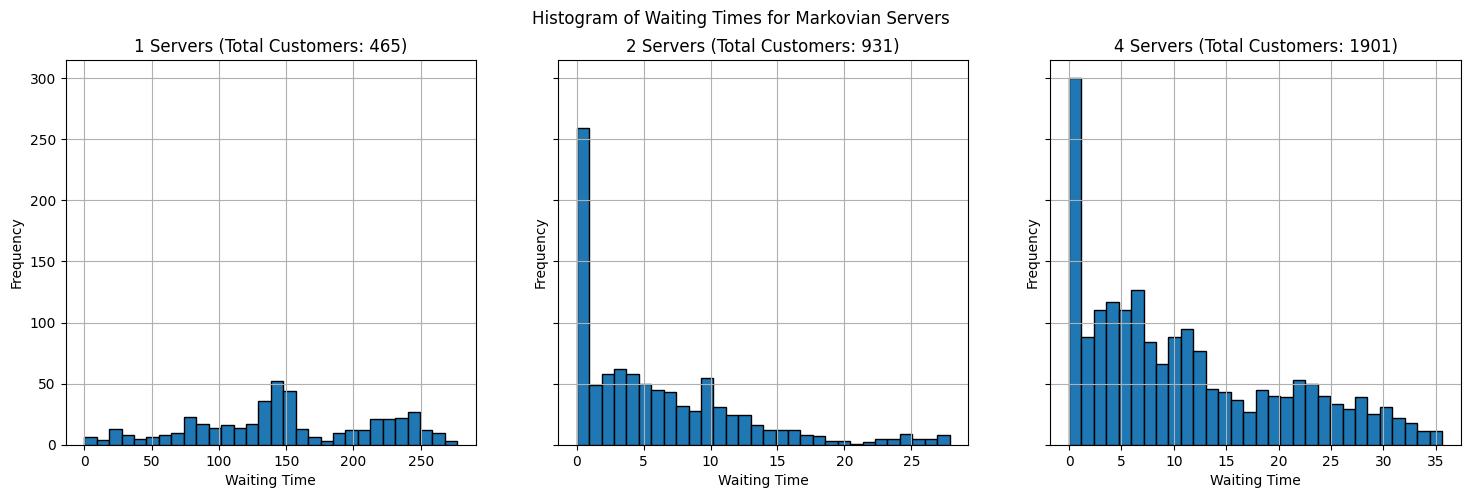

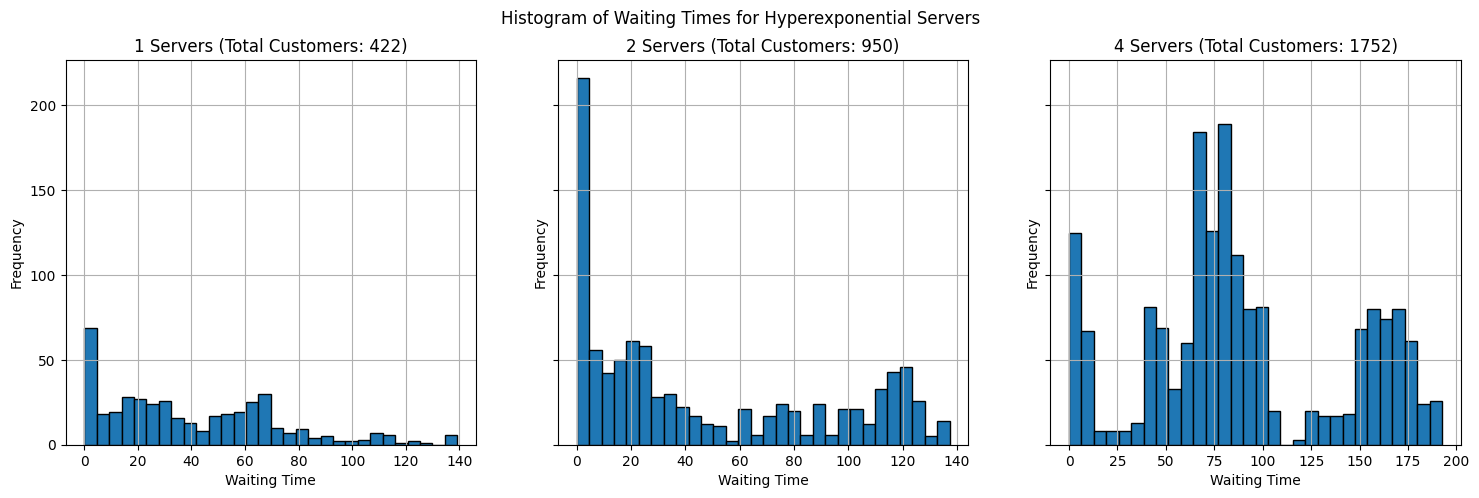

In [258]:
import matplotlib.pyplot as plt

system_load = 0.95
mean_service_time = 4
simulations = 50
servers = [1, 2, 4]
server_types = ["Deterministic",  "Markovian", "Hyperexponential"]
simulation_time = 2000
measurement_time_interval = 5
random.seed(25)

service_rate = 1 / mean_service_time
mean_interarrival_by_n = {n: 1 / (n * system_load * service_rate) for n in servers}

for server_type in server_types:
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f'Histogram of Waiting Times for {server_type} Servers')
    max_y = 0  # To store the maximum y value for setting consistent y-axis limits


    for i, server_count in enumerate(servers):
        specific_mean_interarrival = mean_interarrival_by_n[server_count]
        specific_random_seed = random.randint(0, 10000)

        # Run the simulation for the specific settings
        result = simulate_mmn(specific_mean_interarrival, mean_service_time, server_count, simulation_time, measurement_time_interval, specific_random_seed, server_type)

        # Get the waiting times
        wt = result['waitingtimes']
        total_customers = len(wt)
        

        # Create a histogram of the waiting times
        axs[i].hist(wt, bins=30, edgecolor='black')
        axs[i].set_title(f'{server_count} Servers (Total Customers: {total_customers})')
        axs[i].set_xlabel('Waiting Time')
        axs[i].set_ylabel('Frequency')
        axs[i].grid(True)
        fig.savefig(f"histogram_{server_type}.png", dpi=300)


    plt.show()
